Modelo LSTM para prever o parâmetro pH 

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
import math
import matplotlib.pyplot as plt
plt.rcParams['xtick.labelsize']= 18
plt.rcParams['ytick.labelsize']= 18
plt.rcParams.update({'font.size':18})

In [27]:
str_files = ''

#df = pd.read_csv(str_files + "ph.csv",encoding='utf-8',sep=';')
dateparse = lambda dates:pd.datetime.strptime(dates,'%d/%m/%Y')
df = pd.read_csv(str_files + 'od.CSV',encoding='utf-8',sep=';', parse_dates = ['data_coleta'],index_col=['data_coleta'],date_parser=dateparse)

In [28]:
#df.head()

In [29]:
z = df.loc[df['UGRHI'] == '10 - SOROCABA/MEDIO TIETE']
#z.info()

In [30]:
z = z.dropna(axis=1,how='any')
#for field in z.columns:
    #print(field,'NaN',z[field].isnull().sum())
#print(len(z))

In [31]:
trainingd = z.resample('3M').mean()
trainingd
data = trainingd.iloc[:,1:2].values

train = trainingd.iloc[0:133,1:2].values  
test = trainingd.iloc[133:,1:2].values   
print('treino:',len(train))
print('teste:',len(test))
len(test)

treino: 133
teste: 33


33

In [32]:
sc = MinMaxScaler()
train_normalizado = sc.fit_transform(train)

In [33]:
timestamp = 8
previsores = []
od_real    = []
for i in range(timestamp, len(train)):
    previsores.append(train_normalizado[i-timestamp:i, 0])
    od_real.append(train_normalizado[i, 0])
previsores, od_real = np.array(previsores), np.array(od_real)
previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1], 1))
previsores.shape

(125, 8, 1)

In [41]:
print("Rede Neural LSTM com 10 neuronios nas camadas de entrada e oculta - epocas:100")
model = Sequential() 

model.add(LSTM(units = 10, return_sequences = True, input_shape = (previsores.shape[1], 1))) 
model.add(Dropout(0.2))
model.add(LSTM(units = 10, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 10, return_sequences = False)) 
model.add(Dropout(0.2))
model.add(Dense(units = 1)) 
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

#es = EarlyStopping(monitor='val_loss',mode='auto',verbose = 1,patience=5)

model.fit(previsores, od_real, epochs = 100, batch_size = 32)


Rede Neural LSTM com 10 neuronios nas camadas de entrada e oculta - epocas:100
Train on 125 samples
Epoch 1/100
125/125 [==============================] - 18s 142ms/sample - loss: 0.1829
Epoch 2/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.1527
Epoch 3/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.1219
Epoch 4/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0959
Epoch 5/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0668
Epoch 6/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0513
Epoch 7/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0505
Epoch 8/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0468
Epoch 9/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0485
Epoch 10/100
125/125 [==============================] - 0s 4ms/sample - loss: 0.0482
Epoch 11/100
125/125 [==============================] - 

125/125 [==============================] - 0s 3ms/sample - loss: 0.0397
Epoch 97/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0382
Epoch 98/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0399
Epoch 99/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0432
Epoch 100/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0407


In [42]:
od_real_teste = test
entradas = data[len(data) - len(test) - timestamp:]
entradas = entradas.reshape(-1, 1)
entradas = sc.transform(entradas)

X_teste = []
for i in range(timestamp, timestamp + len(test)):
    X_teste.append(entradas[i-timestamp:i, 0])
X_teste = np.array(X_teste)
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))
previsoes = model.predict(X_teste)
previsoes = sc.inverse_transform(previsoes)

previsoes_treino = model.predict(previsores)
previsoes_treino = sc.inverse_transform(previsoes_treino)

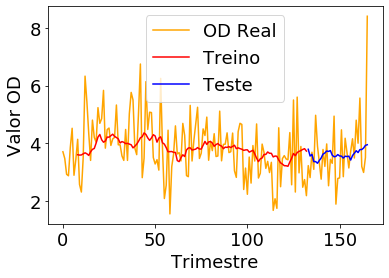

In [43]:
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[timestamp: len(previsoes_treino) + timestamp, :] = previsoes_treino

test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(previsoes_treino)+(timestamp):len(data), :] = previsoes

plt.plot(data, label='OD Real', color='orange')
plt.plot(train_predict_plot, color = 'red', label = 'Treino')
plt.plot(test_predict_plot, color = 'blue', label = 'Teste')
plt.title('')
plt.xlabel('Trimestre')
plt.ylabel('Valor OD')
plt.legend(loc='best')
plt.show()

In [44]:
print('Previsão (média):',round(previsoes.mean(),2))
print('OD Real (média):', round(od_real_teste.mean(),2))
print('Diferença (média):', round(od_real_teste.mean() - previsoes.mean(),2))

Previsão (média): 3.61
OD Real (média): 3.71
Diferença (média): 0.1


In [45]:
train_score10 = model.evaluate(previsores, od_real, verbose=0)
od10_mse  = train_score10
od10_rmse = math.sqrt(train_score10)

print('Pontuação de Treino: {:.2f} MSE ({:.2f} RMSE)'.format(train_score10, math.sqrt(train_score10)))
#test_score10 = mdl.evaluate(X_test, y_test, verbose=0)
#print('Pontuação de teste: {:.2f} MSE ({:.2f} RMSE)'.format(test_score10, math.sqrt(test_score10)))

Pontuação de Treino: 0.04 MSE (0.19 RMSE)


In [46]:
print("Rede Neural LSTM com 25 neuronios nas camadas de entrada e oculta - epocas:100")
model = Sequential() 

model.add(LSTM(units = 25, return_sequences = True, input_shape = (previsores.shape[1], 1))) 
model.add(Dropout(0.2))
model.add(LSTM(units = 25, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 25, return_sequences = False)) 
model.add(Dropout(0.2))
model.add(Dense(units = 1)) 
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

#es = EarlyStopping(monitor='val_loss',mode='auto',verbose = 1,patience=5)

model.fit(previsores, od_real, epochs = 100, batch_size = 32)

Rede Neural LSTM com 25 neuronios nas camadas de entrada e oculta - epocas:100
Train on 125 samples
Epoch 1/100
125/125 [==============================] - 17s 139ms/sample - loss: 0.2144
Epoch 2/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.1607
Epoch 3/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.1039
Epoch 4/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0536
Epoch 5/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0408
Epoch 6/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0491
Epoch 7/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0453
Epoch 8/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0387
Epoch 9/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0398
Epoch 10/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0426
Epoch 11/100
125/125 [==============================] - 

125/125 [==============================] - 0s 3ms/sample - loss: 0.0363
Epoch 97/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0364
Epoch 98/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0353
Epoch 99/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0381
Epoch 100/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0332


In [47]:
od_real_teste = test
entradas = data[len(data) - len(test) - timestamp:]
entradas = entradas.reshape(-1, 1)
entradas = sc.transform(entradas)

X_teste = []
for i in range(timestamp, timestamp + len(test)):
    X_teste.append(entradas[i-timestamp:i, 0])
X_teste = np.array(X_teste)
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))
previsoes = model.predict(X_teste)
previsoes = sc.inverse_transform(previsoes)

previsoes_treino = model.predict(previsores)
previsoes_treino = sc.inverse_transform(previsoes_treino)

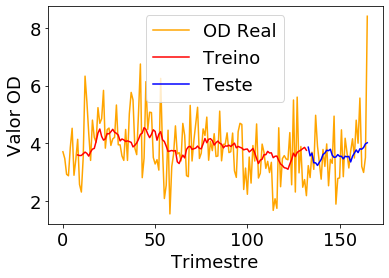

Previsão (média): 3.61
OD Real (média): 3.71
Diferença (média): 0.1
Pontuação de Treino: 0.03 MSE (0.19 RMSE)


In [48]:
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[timestamp: len(previsoes_treino) + timestamp, :] = previsoes_treino

test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(previsoes_treino)+(timestamp):len(data), :] = previsoes

plt.plot(data, label='OD Real', color='orange')
plt.plot(train_predict_plot, color = 'red', label = 'Treino')
plt.plot(test_predict_plot, color = 'blue', label = 'Teste')
plt.title('')
plt.xlabel('Trimestre')
plt.ylabel('Valor OD')
plt.legend()
plt.show()

print('Previsão (média):',round(previsoes.mean(),2))
print('OD Real (média):', round(od_real_teste.mean(),2))
print('Diferença (média):', round(od_real_teste.mean() - previsoes.mean(),2))

train_score25 = model.evaluate(previsores, od_real, verbose=0)
od25_mse  = train_score25
od25_rmse = math.sqrt(train_score25)

print('Pontuação de Treino: {:.2f} MSE ({:.2f} RMSE)'.format(train_score25, math.sqrt(train_score25)))


In [49]:
print("Rede Neural LSTM com 50 neuronios nas camadas de entrada e oculta - epocas:100")
model = Sequential() 

model.add(LSTM(units = 50, return_sequences = True, input_shape = (previsores.shape[1], 1))) 
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = False)) 
model.add(Dropout(0.2))
model.add(Dense(units = 1)) 
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

#es = EarlyStopping(monitor='val_loss',mode='auto',verbose = 1,patience=5)

model.fit(previsores, od_real, epochs = 100, batch_size = 32)

Rede Neural LSTM com 50 neuronios nas camadas de entrada e oculta - epocas:100
Train on 125 samples
Epoch 1/100
125/125 [==============================] - 18s 142ms/sample - loss: 0.2040
Epoch 2/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.1119
Epoch 3/100
125/125 [==============================] - 0s 4ms/sample - loss: 0.0452
Epoch 4/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0597
Epoch 5/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0400
Epoch 6/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0398
Epoch 7/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0435
Epoch 8/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0388
Epoch 9/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0366
Epoch 10/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0399
Epoch 11/100
125/125 [==============================] - 

125/125 [==============================] - 0s 3ms/sample - loss: 0.0355
Epoch 97/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0355
Epoch 98/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0387
Epoch 99/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0361
Epoch 100/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0380


In [50]:
od_real_teste = test
entradas = data[len(data) - len(test) - timestamp:]
entradas = entradas.reshape(-1, 1)
entradas = sc.transform(entradas)

X_teste = []
for i in range(timestamp, timestamp + len(test)):
    X_teste.append(entradas[i-timestamp:i, 0])
X_teste = np.array(X_teste)
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))
previsoes = model.predict(X_teste)
previsoes = sc.inverse_transform(previsoes)

previsoes_treino = model.predict(previsores)
previsoes_treino = sc.inverse_transform(previsoes_treino)
#len(previsoes)

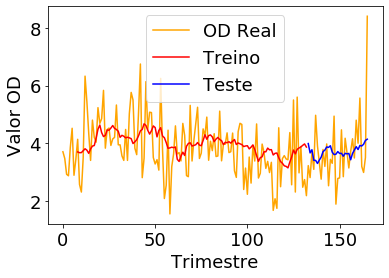

Previsão (média): 3.71
OD Real (média): 3.71
Diferença (média): 0.0
Pontuação de Treino: 0.04 MSE (0.19 RMSE)


In [51]:
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[timestamp: len(previsoes_treino) + timestamp, :] = previsoes_treino

test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(previsoes_treino)+(timestamp):len(data), :] = previsoes

plt.plot(data, label='OD Real', color='orange')
plt.plot(train_predict_plot, color = 'red', label = 'Treino')
plt.plot(test_predict_plot, color = 'blue', label = 'Teste')
plt.title('')
plt.xlabel('Trimestre')
plt.ylabel('Valor OD')
plt.legend()
plt.show()

print('Previsão (média):',round(previsoes.mean(),2))
print('OD Real (média):', round(od_real_teste.mean(),2))
print('Diferença (média):', round(od_real_teste.mean() - previsoes.mean(),2))

train_score50 = model.evaluate(previsores, od_real, verbose=0)
od50_mse  = train_score50
od50_rmse = math.sqrt(train_score50)

print('Pontuação de Treino: {:.2f} MSE ({:.2f} RMSE)'.format(train_score50, math.sqrt(train_score50)))
    


In [52]:
od_media_mse = (od10_mse+od25_mse+od50_mse)/3
od_media_rmse = (od10_rmse+od25_rmse+od50_rmse)/3

print('od_media_mse:', round(od_media_mse,3))
print('od_media_rmse:', round(od_media_rmse,3))

od_media_mse: 0.035
od_media_rmse: 0.187
